In [1]:
!pip3 install pyro-ppl 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 2.3 MB/s 


In [2]:
!pip install extinction

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 2.3 MB/s 


In [3]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import corner
import time

import pyro

import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, Predictive
from pyro.optim import Adam

from scipy.interpolate import interp1d
import h5py
import extinction

from astropy.cosmology import FlatLambdaCDM

from spline_hsiao_fns import *

##Get constants from files

In [5]:
W0 = np.loadtxt("W0.txt")
W1 = np.loadtxt("W1.txt")
time_knots = np.loadtxt("tau_knots.txt")
wavelength_knots = np.loadtxt("l_knots.txt")
L_sigma_epsilon = np.loadtxt("L_Sigma_epsilon.txt")
M0, sigma0, rv, tauA = np.loadtxt("M0_sigma0_RV_tauA.txt")

In [6]:
g_wavelengths, _, g_norm_throughput = np.loadtxt("g_PS1.txt", skiprows = 2, unpack = True)
r_wavelengths, _, r_norm_throughput = np.loadtxt("r_PS1.txt", skiprows = 2, unpack = True)
i_wavelengths, _, i_norm_throughput = np.loadtxt("i_PS1.txt", skiprows = 2, unpack = True)
z_wavelengths, _, z_norm_throughput = np.loadtxt("z_PS1.txt", skiprows = 2, unpack = True)

In [7]:
cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
z = pyro.sample("z", dist.Uniform(0.015, 0.08)).numpy()
true_mu_s = cosmo.distmod(z).value

EBV_MW = 0.

ZPT = 27.5
M0 = -19.5
gamma = np.log(10) / 2.5

Av_obs = EBV_MW * 3.1

In [8]:
dMs = 0.
true_theta = pyro.sample("theta", dist.Uniform(-1.49,2.77)).numpy()
true_Av = pyro.sample("Av", dist.Exponential(1 / 0.252)).numpy()
Rv = 2.659


eps_cov = torch.as_tensor(np.matmul(L_sigma_epsilon, L_sigma_epsilon.T), dtype = torch.float)
# epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))

true_nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov))))
# true_nu = torch.zeros(54)
true_epsilon_interior = np.matmul(L_sigma_epsilon, true_nu.numpy().T)

tmax = pyro.sample("tmax", dist.Uniform(57100,57800)).numpy()
tfirst = pyro.sample("tfirst", dist.Uniform(float(tmax) - 10, float(tmax) - 5)).numpy()
times_MJD = np.array([tfirst + 6*i for i in range(6)])
times = (times_MJD - tmax) / (1 + z)

In [9]:
L_sigma_epsilon.shape

(54, 54)

In [10]:
times

array([-5.04138755,  0.85622957,  6.75384668, 12.6514638 , 18.54908091,
       24.44669803])

In [11]:
hsiao_phase, hsiao_wave, hsiao_flux = read_model_grid()

Things we can pre-calculate
---



In [12]:
def get_lambda_int_for_band(band_wavelengths, z = z):
  source_wavelengths = band_wavelengths / (1 + z)
  return np.linspace(min(source_wavelengths), max(source_wavelengths), 150)

In [13]:
# times_to_interpolate = np.linspace(-10, 40)
times_to_interpolate = times
wavelengths_to_interpolate = get_lambda_int_for_band(z_wavelengths)

In [14]:
Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))
Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))

In [15]:
xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T
xis_matrix.shape

(150, 6)

In [16]:
## interpolate Hsiao coefficient at desired time and wavelength points
S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
for i, wavelength in enumerate(wavelengths_to_interpolate):
  for j, time_point in enumerate(times_to_interpolate):
    S0[i][j] = interpolate_hsiao(time_point, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

In [17]:
min(wavelengths_to_interpolate * (1 + z)), max(wavelengths_to_interpolate * (1 + z))

(7940.157995219609, 9440.39335807811)

In [18]:
min(z_wavelengths), max(z_wavelengths)

(7940.157995219609, 9440.39335807811)

In [19]:
throughput_interpolator = interp1d(z_wavelengths, z_norm_throughput)
## I was getting a floating point problem so I fixed it by removing the last value of wavelengths_to_interpolate (1 + z) and replacing it with the max value
## z_wavelengths, which it should be anyways.
b = throughput_interpolator([z_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z)) + [z_wavelengths[-1]])


xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)
h.shape

(150,)

## Simulating a curve

In [20]:
def get_flux_from_params(epsilon_interior, theta, mu_s, dMs, Av, W0 = W0, W1 = W1, xis_matrix = xis_matrix, S0 = S0, h = h, Jl = Jl, Jt = Jt):

  epsilon = np.zeros_like(W0)   ## populate epsilon matrix
  epsilon[1:-1] = epsilon_interior.numpy().reshape((9,6), order = 'F')

  W = W0 + theta.numpy()*W1 + epsilon

  JlWJt = np.matmul(Jl, np.matmul(W, Jt.T))

  Stilde = S0 * np.exp(-gamma * (JlWJt + Av.numpy() * xis_matrix))

  f = 10**(0.4 * (ZPT - mu_s.numpy() - M0 - dMs.numpy())) * np.matmul(h,Stilde)

  return f

In [21]:
flux = get_flux_from_params(torch.as_tensor(true_epsilon_interior), torch.as_tensor(true_theta), torch.as_tensor(true_mu_s), torch.as_tensor(dMs), torch.as_tensor(true_Av))

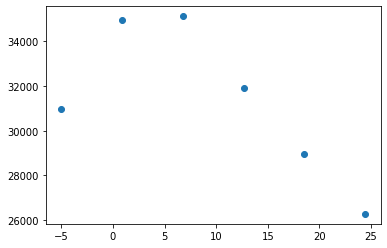

In [22]:
plt.plot(times, flux, 'o')

Simulate for all bands at once

In [23]:
times_to_interpolate = times
Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))

wavelengths_dict = {'g':g_wavelengths, 'r':r_wavelengths, 'i':i_wavelengths, 'z':z_wavelengths}
norm_throughput_dict = {'g':g_norm_throughput, 'r':r_norm_throughput, 'i':i_norm_throughput, 'z':z_norm_throughput}

bands = ['g', 'r', 'i', 'z']
all_band_fluxes = []

band_Jl = {}
band_xis_matrix = {}
band_S0 = {}
band_h = {}

for band in bands:
  band_wavelengths = wavelengths_dict[band]
  band_norm_throughput = norm_throughput_dict[band]

  wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths)
  
  Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
  band_Jl[band] = Jl
  xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
  xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T
  band_xis_matrix[band] = xis_matrix

  S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
  for i, wavelength in enumerate(wavelengths_to_interpolate):
    for j, time_point in enumerate(times_to_interpolate):
      S0[i][j] = interpolate_hsiao(time_point, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

  band_S0[band] = S0

  throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
  b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z)) + [band_wavelengths[-1]])

  xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
  dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
  h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)

  band_h[band] = h

  band_flux = get_flux_from_params(torch.as_tensor(true_epsilon_interior), torch.as_tensor(true_theta), 
                              torch.as_tensor(true_mu_s), torch.as_tensor(dMs), torch.as_tensor(true_Av),
                              xis_matrix = xis_matrix, S0 = S0, h = h, Jt = Jt, Jl = Jl)
  
  all_band_fluxes.append(band_flux)

all_band_fluxes = np.array(all_band_fluxes)

In [24]:
all_band_fluxes

array([[52404.78791795, 58130.48517214, 46895.53373331, 29594.87249554,
        17534.09816852, 11053.10685706],
       [48598.45915388, 57606.45010794, 51917.48323974, 38853.5553826 ,
        30378.88431752, 24328.28716849],
       [40029.63847723, 34592.75297371, 29652.90171608, 23438.58647597,
        22959.20711752, 21189.75397589],
       [30952.72217752, 34969.49926255, 35130.82068917, 31905.81287968,
        28952.39289117, 26269.58565121]])

Now let's actually make the model
---

In [25]:
true_theta, true_mu_s, true_Av

(array(0.16933894, dtype=float32),
 34.28752492922126,
 array(0.47674337, dtype=float32))

In [26]:
true_nu

tensor([ 0.2029, -0.9145, -1.3897,  0.0876, -0.8603,  0.5921,  0.7950, -0.5205,
         0.2642, -1.3049,  1.1322,  1.4455,  1.6965, -0.0512,  0.7825,  0.8741,
         0.3095,  1.1430,  0.3846,  1.5529,  0.3076, -1.5758, -0.3778, -1.1325,
         0.7280,  2.2342,  0.1647, -1.1273,  0.9676, -0.7893, -0.2322, -0.4009,
        -0.7519, -0.6482, -0.8847, -0.4894, -1.9095, -1.5893,  2.6921,  1.3382,
         1.2126, -0.4630,  0.6545,  1.6149,  0.8439, -0.2089,  0.7539, -0.3799,
         0.2284,  0.4332, -0.1930, -0.5612,  0.3046, -0.6689])

In [214]:
def model_vi(obs):
  # epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))

  nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov))))
  # nu = torch.zeros(54)
  epsilon_interior = torch.matmul(torch.as_tensor(L_sigma_epsilon, dtype = torch.float), nu)
  # print(epsilon_interior)

  # theta = pyro.sample("theta", dist.Uniform(low=-1.49, high=2.77))
  theta = pyro.sample("theta", dist.Normal(0., 1.0))
  # theta = torch.as_tensor(0.03430605)

  # theta = torch.as_tensor(-0.9835187)
  mu_s = pyro.sample("mu_s", dist.Normal(34.5, 1.)) ## fix this later
  # mu_s = torch.as_tensor(37.248927127193724)

  # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
  dMs = torch.tensor(0.)
  Av = pyro.sample("Av", dist.Exponential(1 / 0.252))
  # Av = torch.tensor(7.2387767)
  # Av = pyro.sample("Av", dist.Normal(0.27, 1.))

  epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)

  W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

  generated_fluxes = []

  for band in bands:
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]

    JlWJt = torch.matmul(torch.as_tensor(Jl), torch.matmul(W, torch.as_tensor(Jt.T)))

    Stilde = torch.as_tensor(S0) * torch.exp(-gamma * (JlWJt + Av * torch.as_tensor(xis_matrix)))

    f = 10**(0.4 * (torch.as_tensor(ZPT) - mu_s - torch.as_tensor(M0) - dMs)) * torch.matmul(torch.as_tensor(h), torch.as_tensor(Stilde))
    generated_fluxes.append(f)

  generated_fluxes = torch.stack(generated_fluxes)
  # print(generated_fluxes)

  with pyro.plate("bands"):
    with pyro.plate("observations"):
      pyro.sample("flux", dist.Normal(generated_fluxes, 0.02 * generated_fluxes), obs = obs)

In [204]:
torch.as_tensor(all_band_fluxes)

tensor([[52404.7879, 58130.4852, 46895.5337, 29594.8725, 17534.0982, 11053.1069],
        [48598.4592, 57606.4501, 51917.4832, 38853.5554, 30378.8843, 24328.2872],
        [40029.6385, 34592.7530, 29652.9017, 23438.5865, 22959.2071, 21189.7540],
        [30952.7222, 34969.4993, 35130.8207, 31905.8129, 28952.3929, 26269.5857]],
       dtype=torch.float64)

In [205]:
model_vi(torch.as_tensor(all_band_fluxes))

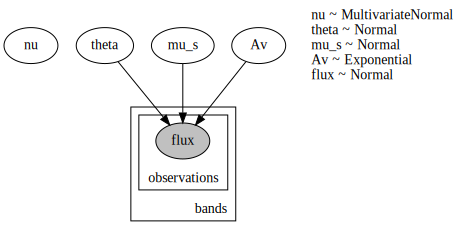

In [174]:
pyro.render_model(model_vi, model_args = (torch.as_tensor(all_band_fluxes),), render_distributions=True, render_params = True)

In [210]:
# autoguide_vi = pyro.infer.autoguide.AutoDiagonalNormal(model_vi)
autoguide_vi = pyro.infer.autoguide.AutoMultivariateNormal(model_vi, init_loc_fn = pyro.infer.autoguide.initialization.init_to_sample(), init_scale = 0.8)

In [104]:
class CustomMultivariateNormal(pyro.infer.autoguide.AutoMultivariateNormal):
  def __init__(self, model, diag_eps = True, no_eps_other_params = True):
        self.diag_eps = diag_eps
        self.no_eps_other_params = no_eps_other_params
        super().__init__(model)

  def get_posterior(self, *args, **kwargs):
    """
    Returns a MultivariateNormal posterior distribution.
    """
    scale_tril = self.scale[..., None] * self.scale_tril
    
    # # cov = torch.mm(scale_tril, scale_tril.T)
    # # corner = cov[54:57,54:57]
    # # chol_corner = torch.linalg.cholesky(corner)
    # print(scale_tril.detach().numpy())
    # plt.matshow(scale_tril.detach().numpy())
    # plt.colorbar(norm=colors.LogNorm())

    if self.diag_eps:
      for i in range(54):
        for j in range(i):
          scale_tril[i][j] = 0
          scale_tril[j][i] = 0
    if self.no_eps_other_params:
      for i in range(54, 57):
        for j in range(54):
          scale_tril[i][j] = 0
          scale_tril[j][i] = 0
    # plt.matshow(scale_tril.detach().numpy())
    # plt.matshow(torch.mm(scale_tril, scale_tril.T).detach().numpy())
    return dist.MultivariateNormal(self.loc, scale_tril = scale_tril)

In [211]:
pyro.get_param_store().clear()
adam = pyro.optim.Adam({"lr": 0.001, "betas": (0.90, 0.999)}, {"clip_norm": 10.0})
# adam = pyro.optim.SGD({"lr": 0.1})


svi = SVI(model_vi, autoguide_vi, adam, loss=Trace_ELBO().differentiable_loss)
# svi = SVI(model_vi, custom_guide, adam, loss=Trace_ELBO().differentiable_loss)

for i in range(10):
  svi.step(torch.as_tensor(all_band_fluxes))

In [106]:
# latent_dim = 57
# pyro.param("auto_scale_tril", torch.tril(torch.rand(latent_dim, latent_dim)),
#                    constraint=constraints.lower_cholesky)

In [176]:
def train(model, guide, lr=0.01, n_steps=5000, verbose = True):
    pyro.get_param_store().clear()
    adam_params = {"lr": lr, "betas": (0.95, 0.999)}
    # adam = pyro.optim.Adam({"lr": 0.05}, {"clip_norm": 10.0})
    adam = pyro.optim.ClippedAdam(adam_params)
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    losses = []
    losses_every_500 = []

    for step in range(n_steps):
        loss = svi.step(torch.as_tensor(all_band_fluxes))
        losses.append(loss)
        if verbose and step % 500 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))
            losses_every_500.append(loss)
            ## if it hasn't decreased in 3 steps, end fitting
            # if step > 2000:
            #  if losses_every_500[-1] >= losses_every_500[-2] and losses_every_500[-2] >= losses_every_500[-3]:
            #   break
    return losses

In [182]:
start_time = time.time()
losses = train(model_vi, autoguide_vi, lr = 0.005, n_steps = 20000)
end_time = time.time()
print("Time:", end_time - start_time, "seconds")

[iter 0]  loss: 21079.4754
[iter 500]  loss: 3180.8077
[iter 1000]  loss: 321.4526
[iter 1500]  loss: 790.5181
[iter 2000]  loss: 315.5209
[iter 2500]  loss: 268.3072
[iter 3000]  loss: 237.1017
[iter 3500]  loss: 234.5939
[iter 4000]  loss: 221.6290
[iter 4500]  loss: 224.4963
[iter 5000]  loss: 217.7158
[iter 5500]  loss: 219.0572
[iter 6000]  loss: 216.4640
[iter 6500]  loss: 216.5876
[iter 7000]  loss: 221.8659
[iter 7500]  loss: 217.6956
[iter 8000]  loss: 219.3208
[iter 8500]  loss: 217.3293
[iter 9000]  loss: 215.1410
[iter 9500]  loss: 219.5914
[iter 10000]  loss: 208.4942
[iter 10500]  loss: 223.7918
[iter 11000]  loss: 214.4280
[iter 11500]  loss: 218.4540
[iter 12000]  loss: 224.7290
[iter 12500]  loss: 218.5724
[iter 13000]  loss: 216.2076
[iter 13500]  loss: 215.7846
[iter 14000]  loss: 214.1705
[iter 14500]  loss: 226.2421
[iter 15000]  loss: 208.6785
[iter 15500]  loss: 215.7457
[iter 16000]  loss: 219.8351
[iter 16500]  loss: 216.6838
[iter 17000]  loss: 220.2073
[iter 

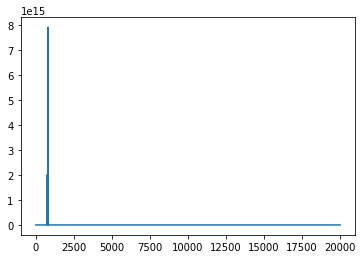

In [36]:
plt.plot(losses)

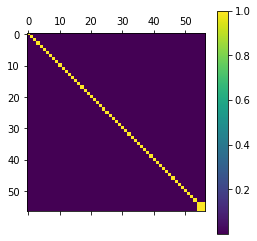

In [37]:
cov = np.ones((57, 57))
for i in range(54):
  for j in range(i):
    cov[i][j] = 0.0001
    cov[j][i] = 0.0001
for i in range(54, 57):
  for j in range(54):
    cov[i][j] = 0.0001
    cov[j][i] = 0.0001
plt.matshow(cov)
plt.colorbar()

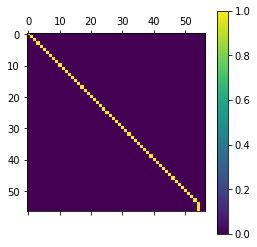

In [38]:
plt.matshow(np.linalg.cholesky(cov))
plt.colorbar()

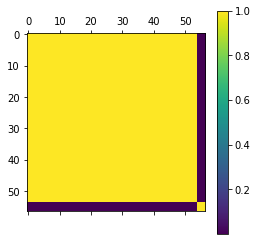

In [39]:
cov = np.ones((57, 57))
# for i in range(54):
#   for j in range(i):
#     cov[i][j] = 0.0001
#     cov[j][i] = 0.0001
for i in range(54, 57):
  for j in range(54):
    cov[i][j] = 0.0001
    cov[j][i] = 0.0001
plt.matshow(cov)
plt.colorbar()

In [40]:
autoguide_vi.median()['theta'], true_theta

(tensor(0.3351), array(0.16933894, dtype=float32))

In [41]:
autoguide_vi.median()['Av'], true_Av

(tensor(0.4641), array(0.47674337, dtype=float32))

In [42]:
autoguide_vi.median()['mu_s'], true_mu_s

(tensor(34.2834), 34.28752492922126)

In [43]:
autoguide_vi.median()['nu'], true_nu

(tensor([-0.1291, -1.0292, -0.0945, -0.6024, -0.8486,  0.4736,  0.1430,  0.4229,
          0.4897,  0.1044, -0.2162,  0.6623,  1.1075,  0.5543,  0.4654, -0.0499,
         -0.1469, -0.0832,  0.4731,  0.4262, -0.3403, -1.2292, -0.6593, -1.1507,
         -0.0969, -0.1800, -0.2763, -0.0016, -0.3155, -0.0327, -0.0516,  0.0344,
         -0.2612, -0.1497,  0.0135,  0.1018, -0.2653, -0.5801,  0.0757,  0.6140,
          0.3458, -0.0849,  0.0286,  0.0317, -0.0033,  0.0175,  0.0865, -0.1191,
         -0.1383, -0.1087,  0.0378, -0.0178, -0.0179, -0.0572]),
 tensor([ 0.2029, -0.9145, -1.3897,  0.0876, -0.8603,  0.5921,  0.7950, -0.5205,
          0.2642, -1.3049,  1.1322,  1.4455,  1.6965, -0.0512,  0.7825,  0.8741,
          0.3095,  1.1430,  0.3846,  1.5529,  0.3076, -1.5758, -0.3778, -1.1325,
          0.7280,  2.2342,  0.1647, -1.1273,  0.9676, -0.7893, -0.2322, -0.4009,
         -0.7519, -0.6482, -0.8847, -0.4894, -1.9095, -1.5893,  2.6921,  1.3382,
          1.2126, -0.4630,  0.6545,  1.6149,

In [44]:
custom_guide = CustomMultivariateNormal(model_vi)
start_time = time.time()
losses = train(model_vi, custom_guide, n_steps = 10000)
end_time = time.time()
print("Time:", end_time - start_time, "seconds")

[iter 0]  loss: 1450.3904
[iter 500]  loss: 230.5599
[iter 1000]  loss: 230.8583
[iter 1500]  loss: 233.6626
[iter 2000]  loss: 227.4262
[iter 2500]  loss: 227.1441
[iter 3000]  loss: 230.3882
[iter 3500]  loss: 242.1045
[iter 4000]  loss: 228.5628
[iter 4500]  loss: 232.5425
[iter 5000]  loss: 227.2593
[iter 5500]  loss: 237.8638
[iter 6000]  loss: 220.7144
[iter 6500]  loss: 225.2243
[iter 7000]  loss: 232.7209
[iter 7500]  loss: 242.8447
[iter 8000]  loss: 229.4766
[iter 8500]  loss: 227.4838
[iter 9000]  loss: 247.6196
[iter 9500]  loss: 226.7435
Time: 567.8855736255646 seconds


In [45]:
custom_guide_full_eps = CustomMultivariateNormal(model_vi, diag_eps = False)
start_time = time.time()
losses = train(model_vi, custom_guide_full_eps, n_steps = 10000)
end_time = time.time()
print("Time:", end_time - start_time, "seconds")

[iter 0]  loss: 1155.1474
[iter 500]  loss: 234.1566
[iter 1000]  loss: 228.1704
[iter 1500]  loss: 224.8342
[iter 2000]  loss: 230.5874
[iter 2500]  loss: 219.3582
[iter 3000]  loss: 228.7790
[iter 3500]  loss: 220.5646
[iter 4000]  loss: 223.9975
[iter 4500]  loss: 221.9286
[iter 5000]  loss: 232.5610
[iter 5500]  loss: 218.0528
[iter 6000]  loss: 217.6663
[iter 6500]  loss: 221.2876
[iter 7000]  loss: 228.5067
[iter 7500]  loss: 221.5690
[iter 8000]  loss: 231.1412
[iter 8500]  loss: 220.3370
[iter 9000]  loss: 219.0280
[iter 9500]  loss: 225.0548
Time: 110.24787211418152 seconds


In [46]:
autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi)
start_time = time.time()
losses = train(model_vi, autoguide_laplace, n_steps = 10000)
end_time = time.time()
print("Time:", end_time - start_time, "seconds")

[iter 0]  loss: 3271.7371
[iter 500]  loss: 236.0693
[iter 1000]  loss: 235.8214
[iter 1500]  loss: 235.7928
[iter 2000]  loss: 235.7893
[iter 2500]  loss: 235.8086
[iter 3000]  loss: 235.7920
[iter 3500]  loss: 235.7893
[iter 4000]  loss: 235.8089
[iter 4500]  loss: 235.7923
[iter 5000]  loss: 235.7894
[iter 5500]  loss: 235.8097
[iter 6000]  loss: 235.7926
[iter 6500]  loss: 235.7896
[iter 7000]  loss: 235.8105
[iter 7500]  loss: 235.7929
[iter 8000]  loss: 235.7897
[iter 8500]  loss: 235.8109
[iter 9000]  loss: 235.7930
[iter 9500]  loss: 235.7898
Time: 49.82641553878784 seconds


In [47]:
new_laplace_approx_guide = autoguide_laplace.laplace_approximation(torch.as_tensor(all_band_fluxes))
losses = train(model_vi, new_laplace_approx_guide, n_steps = 10000)

[iter 0]  loss: 212.4880
[iter 500]  loss: 212.0596
[iter 1000]  loss: 212.4035
[iter 1500]  loss: 214.0389
[iter 2000]  loss: 212.1721
[iter 2500]  loss: 213.5734
[iter 3000]  loss: 212.2601
[iter 3500]  loss: 223.1848
[iter 4000]  loss: 215.4145
[iter 4500]  loss: 213.4687
[iter 5000]  loss: 212.7087
[iter 5500]  loss: 212.4066
[iter 6000]  loss: 212.0735
[iter 6500]  loss: 212.3728
[iter 7000]  loss: 212.0292
[iter 7500]  loss: 212.5757
[iter 8000]  loss: 213.1176
[iter 8500]  loss: 212.1512
[iter 9000]  loss: 217.8108
[iter 9500]  loss: 212.3831


In [48]:
def calculate_all_fluxes_from_params(nu, theta, mu_s, dMs, Av):
  times_to_interpolate = np.linspace(-10, 30)
  Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))

  epsilon_interior = np.matmul(L_sigma_epsilon, nu.numpy().T)

  epsilon = np.zeros_like(W0)   ## populate epsilon matrix
  epsilon[1:-1] = epsilon_interior.reshape((9,6), order = 'F')

  W = W0 + theta.numpy()*W1 + epsilon

  generated_fluxes_from_params = []

  for band in bands:
    band_wavelengths = wavelengths_dict[band]
    band_norm_throughput = norm_throughput_dict[band]

    Jl = band_Jl[band]
    # xis_matrix = band_xis_matrix[band]
    # h = band_h[band]

    wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths)
    
    # Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
    xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
    xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T

    S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
    for i, wavelength in enumerate(wavelengths_to_interpolate):
      for j, time in enumerate(times_to_interpolate):
        S0[i][j] = interpolate_hsiao(time, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

    throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
    b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z)) + [band_wavelengths[-1]])

    xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
    dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
    h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)

    band_flux = get_flux_from_params(torch.as_tensor(epsilon_interior), torch.as_tensor(theta), 
                                torch.as_tensor(mu_s), torch.as_tensor(dMs), torch.as_tensor(Av),
                                xis_matrix = xis_matrix, S0 = S0, h = h, Jt = Jt, Jl = Jl)
    
    generated_fluxes_from_params.append(band_flux)
  
  return np.array(generated_fluxes_from_params)

In [49]:
median_fluxes = calculate_all_fluxes_from_params(autoguide_vi.median()['nu'], autoguide_vi.median()['theta'], autoguide_vi.median()['mu_s'], torch.as_tensor(0.), autoguide_vi.median()['Av'])

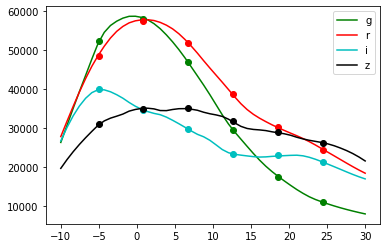

In [50]:
colors  = ['g', 'r', 'c', 'k']
for i, band_flux in enumerate(median_fluxes):
  plt.plot(np.linspace(-10, 30), band_flux, label = bands[i], color = colors[i])
for i, band_flux in enumerate(all_band_fluxes):
  plt.plot(times, band_flux, 'o',color = colors[i])
plt.legend()

In [51]:
lower_quartile = autoguide_vi.quantiles([0.5 - 0.341])
upper_quartile = autoguide_vi.quantiles([0.5 + 0.341])
median = autoguide_vi.quantiles([0.5])

In [54]:
upper_bound = calculate_all_fluxes_from_params(upper_quartile['nu'], upper_quartile['theta'], upper_quartile['mu_s'], torch.as_tensor(0.), upper_quartile['Av'])
lower_bound = calculate_all_fluxes_from_params(lower_quartile['nu'], lower_quartile['theta'], lower_quartile['mu_s'], torch.as_tensor(0.), lower_quartile['Av'])
median_flux = calculate_all_fluxes_from_params(median['nu'], median['theta'], median['mu_s'], torch.as_tensor(0.), median['Av'])

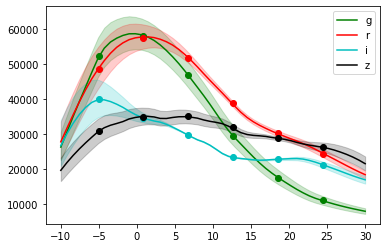

In [55]:
colors  = ['g', 'r', 'c', 'k']
for i, band_flux in enumerate(median_flux):
  plt.plot(np.linspace(-10, 30), band_flux, label = bands[i], color = colors[i])
  plt.fill_between(np.linspace(-10, 30), upper_bound[i], lower_bound[i], color = colors[i], alpha = 0.2)
for i, band_flux in enumerate(all_band_fluxes):
  plt.plot(times, band_flux, 'o',color = colors[i])
plt.legend()

## Compare with MCMC

In [56]:
def model_mcmc(obs = torch.as_tensor(all_band_fluxes)):
  # epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))

  nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov))))
  # nu = torch.zeros(54)
  nu = torch.as_tensor(nu, dtype = torch.double)
  # print(nu.type())
  epsilon_interior = torch.matmul(torch.as_tensor(L_sigma_epsilon, dtype = torch.double), nu)
  # print(epsilon_interior)

  # theta = pyro.sample("theta", dist.Uniform(low=-1.49, high=2.77))
  theta = pyro.sample("theta", dist.Normal(0., 1.0))
  # theta = torch.as_tensor(0.03430605)

  # theta = torch.as_tensor(-0.9835187)
  mu_s = pyro.sample("mu_s", dist.Normal(true_mu_s, 10.)) ## fix this later
  # mu_s = pyro.sample("mu_s", dist.Uniform(0., 999999999)) ## fix this later

  # mu_s = torch.as_tensor(37.248927127193724)

  # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
  dMs = torch.tensor(0.)
  Av = pyro.sample("Av", dist.Exponential(1 / 0.252))
  # Av = torch.tensor(7.2387767)
  # Av = pyro.sample("Av", dist.Normal(0.27, 1.))

  epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)

  W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

  generated_fluxes = []

  for band in bands:
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]

    JlWJt = torch.matmul(torch.as_tensor(Jl), torch.matmul(W, torch.as_tensor(Jt.T)))

    Stilde = torch.as_tensor(S0) * torch.exp(-gamma * (JlWJt + Av * torch.as_tensor(xis_matrix)))

    f = 10**(0.4 * (torch.as_tensor(ZPT) - mu_s - torch.as_tensor(M0) - dMs)) * torch.matmul(torch.as_tensor(h), torch.as_tensor(Stilde))
    generated_fluxes.append(f)

  generated_fluxes = torch.stack(generated_fluxes)
  # print(generated_fluxes)

  with pyro.plate("bands"):
    with pyro.plate("observations"):
      pyro.sample("flux", dist.Normal(generated_fluxes, 0.02 * generated_fluxes), obs = obs)

In [57]:
num_chains = 2

initial_params = {'mu_s':torch.tensor([pyro.sample("mu_s", dist.Normal(true_mu_s, 0.5)) for i in range(num_chains)]),
                  'theta': torch.tensor([pyro.sample("theta", dist.Normal(0., 1.0)) for i in range(num_chains)]),
                  'Av': torch.tensor([pyro.sample("Av", dist.Exponential(1 / 0.252)) for i in range(num_chains)]),
                  'nu': torch.stack([pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov)))) for i in range(num_chains)])}

In [58]:
nuts_kernel = pyro.infer.NUTS(model_mcmc, adapt_step_size=True)

mcmc = pyro.infer.MCMC(nuts_kernel, initial_params = initial_params, num_samples=600, warmup_steps=250, num_chains = num_chains, disable_progbar = True)

start_time = time.time()
mcmc.run(torch.as_tensor(all_band_fluxes))
end_time = time.time()
print("Total:", end_time - start_time, "seconds")

/usr/local/lib/python3.7/dist-packages/pyro/infer/mcmc/api.py:500: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  num_chains, available_cpu


Total: 960.3128623962402 seconds


In [59]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        Av      0.44      0.06      0.44      0.33      0.54    481.98      1.00
      mu_s     34.30      0.07     34.30     34.20     34.41    450.41      1.00
     nu[0]     -0.09      0.84     -0.11     -1.33      1.43    953.89      1.00
     nu[1]     -0.91      0.66     -0.93     -1.97      0.21    798.74      1.00
     nu[2]     -0.06      0.91     -0.07     -1.54      1.42    930.68      1.00
     nu[3]     -0.66      0.54     -0.65     -1.55      0.20    764.22      1.01
     nu[4]     -0.91      0.55     -0.91     -1.90     -0.08   1104.23      1.00
     nu[5]      0.41      0.42      0.41     -0.37      1.03    798.02      1.00
     nu[6]      0.14      1.00      0.15     -1.57      1.62   1230.49      1.00
     nu[7]      0.33      0.93      0.33     -1.21      1.83   1348.13      1.00
     nu[8]      0.43      0.97      0.45     -1.10      2.01    852.35      1.00
     nu[9]      0.27      0

In [60]:
mcmc.get_samples(num_samples = 100)['theta'].median(), mcmc.get_samples(num_samples = 100)['Av'].median(), mcmc.get_samples(num_samples = 100)['mu_s'].median()

(tensor(0.3274, dtype=torch.float64),
 tensor(0.4358, dtype=torch.float64),
 tensor(34.2930, dtype=torch.float64))

In [61]:
median['theta'], median['Av'], median['mu_s']

(tensor([0.3351]), tensor([0.4641]), tensor([34.2834]))

In [62]:
true_theta, true_Av, true_mu_s

(array(0.16933894, dtype=float32),
 array(0.47674337, dtype=float32),
 34.28752492922126)

In [144]:
mcmc_median_vals = {}
for param in ['theta', 'Av', 'mu_s', 'nu']:
  if param == 'nu':
    mcmc_median_vals[param] = mcmc.get_samples(num_samples = 100)[param].median(dim = 0).values.float()
  else:
    mcmc_median_vals[param] = mcmc.get_samples(num_samples = 100)[param].median().float()

In [139]:
mcmc_median_vals

{'Av': tensor(0.4482, dtype=torch.float64),
 'mu_s': tensor(34.2917, dtype=torch.float64),
 'nu': tensor([-0.1213, -0.7917, -0.0063, -0.7042, -0.9515,  0.3655,  0.3197,  0.4048,
          0.2173,  0.2072, -0.0232,  0.7539,  0.9849,  0.3762,  0.4301,  0.0549,
         -0.2021, -0.1860,  0.5687,  0.4748, -0.1986, -1.0730, -0.7696, -1.3535,
          0.0230, -0.3421, -0.0685,  0.0916, -0.1859,  0.1858,  0.0896,  0.0669,
         -0.3286, -0.0799,  0.1117,  0.2057, -0.1140, -0.5429,  0.0326,  0.8568,
          0.4977, -0.1069, -0.1414,  0.0381,  0.0374,  0.0113, -0.1605, -0.0732,
         -0.1680, -0.0575, -0.1949, -0.1674, -0.2196,  0.2749],
        dtype=torch.float64),
 'theta': tensor(0.3228, dtype=torch.float64)}

In [63]:
mcmc.get_samples(num_samples = 100)['Av']

tensor([0.4733, 0.5587, 0.3616, 0.3721, 0.3966, 0.5549, 0.4226, 0.3394, 0.2678,
        0.4800, 0.5219, 0.3906, 0.4423, 0.4335, 0.4699, 0.4561, 0.4068, 0.4929,
        0.4094, 0.3945, 0.4091, 0.4266, 0.4924, 0.4039, 0.4631, 0.5022, 0.5294,
        0.3301, 0.4959, 0.4338, 0.4225, 0.3796, 0.4704, 0.4229, 0.3912, 0.3986,
        0.3289, 0.4750, 0.3830, 0.4060, 0.4173, 0.4255, 0.4791, 0.4827, 0.4729,
        0.3564, 0.3872, 0.3974, 0.4465, 0.4273, 0.4039, 0.4872, 0.3822, 0.3601,
        0.3730, 0.3840, 0.4208, 0.5212, 0.4297, 0.4338, 0.3539, 0.3345, 0.5129,
        0.4535, 0.2737, 0.4531, 0.3377, 0.5760, 0.4865, 0.4176, 0.4911, 0.4090,
        0.4499, 0.5643, 0.4200, 0.3570, 0.4423, 0.3549, 0.5335, 0.3756, 0.3702,
        0.4455, 0.4799, 0.4420, 0.3830, 0.3389, 0.3739, 0.4265, 0.4041, 0.3920,
        0.4688, 0.3618, 0.2992, 0.4034, 0.4694, 0.3369, 0.4597, 0.3964, 0.4351,
        0.3270], dtype=torch.float64)

In [64]:
mcmc_posterior_samples = Predictive(model_mcmc, num_samples = 100)(None,)
# mcmc_posterior_samples

In [65]:
posterior_samples = Predictive(model_vi, guide = autoguide_vi, num_samples = 100)(None,)
posterior_samples['Av'][:,0,0].shape

torch.Size([100])

In [66]:
custom_guide_samples = Predictive(model_vi, guide = custom_guide, num_samples = 100)(None,)
custom_guide_samples['Av'][:,0,0].shape

torch.Size([100])

In [67]:
custom_guide_full_eps
custom_guide_full_eps_samples = Predictive(model_vi, guide = custom_guide_full_eps, num_samples = 100)(None,)
custom_guide_full_eps_samples['Av'][:,0,0].shape

torch.Size([100])

In [68]:
custom_guide_smooth_curves = []
for nu, theta, mu_s, Av in zip(custom_guide_samples['nu'][:,0,0], custom_guide_samples['theta'][:,0,0], custom_guide_samples['mu_s'][:,0,0], custom_guide_samples['Av'][:,0,0]):
  # print(nu, theta, mu_s, Av)
  custom_guide_smooth_curves.append(calculate_all_fluxes_from_params(nu, theta, mu_s, torch.as_tensor(0.), Av))

In [69]:
posterior_smooth_curves = []
for nu, theta, mu_s, Av in zip(posterior_samples['nu'][:,0,0], posterior_samples['theta'][:,0,0], posterior_samples['mu_s'][:,0,0], posterior_samples['Av'][:,0,0]):
  # print(nu, theta, mu_s, Av)
  posterior_smooth_curves.append(calculate_all_fluxes_from_params(nu, theta, mu_s, torch.as_tensor(0.), Av))

In [70]:
# posterior_smooth_curves = []
# for this_theta, this_mu_s, this_Av in zip(posterior_samples['theta'][:,0,0], posterior_samples['mu_s'][:,0,0], posterior_samples['Av'][:,0,0]):
#   # print(nu, theta, mu_s, Av)
#   posterior_smooth_curves.append(calculate_all_fluxes_from_params(true_nu, this_theta, this_mu_s, torch.as_tensor(0.), this_Av))

In [71]:
posterior_smooth_curves = np.array(posterior_smooth_curves)

In [72]:
median_posterior_fit = np.median(posterior_smooth_curves, axis = 0)
upper_posterior_fit = np.percentile(posterior_smooth_curves, 50 + 34.1, axis = 0)
lower_posterior_fit = np.percentile(posterior_smooth_curves, 50 - 34.1, axis = 0)

Text(0.5, 1.0, 'Posterior samples from VI')

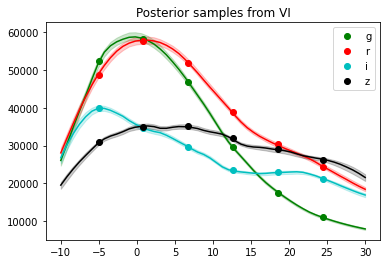

In [73]:
colors  = ['g', 'r', 'c', 'k']
for i, band_flux in enumerate(median_posterior_fit):
    plt.plot(np.linspace(-10, 30), band_flux, color = colors[i])
    plt.fill_between(np.linspace(-10, 30), upper_posterior_fit[i], lower_posterior_fit[i], color = colors[i], alpha = 0.2)
for i, band_flux in enumerate(all_band_fluxes):
  plt.plot(times, band_flux, 'o',color = colors[i], label = bands[i])
plt.legend()
plt.title("Posterior samples from VI")

In [74]:
# mcmc_posterior_samples

In [75]:
mcmc_smooth_curves = []

mcmc_posterior_samples = mcmc.get_samples(num_samples = 100)
# print(mcmc_posterior_samples)
for nu, theta, mu_s, Av in zip(mcmc_posterior_samples['nu'], mcmc_posterior_samples['theta'], mcmc_posterior_samples['mu_s'], mcmc_posterior_samples['Av']):
  # print(nu, theta, mu_s, Av)
  mcmc_smooth_curves.append(calculate_all_fluxes_from_params(nu, theta, mu_s, torch.as_tensor(0.), Av))

In [76]:
# mcmc_smooth_curves = []

# mcmc_posterior_samples = mcmc.get_samples(num_samples = 100)
# # print(mcmc_posterior_samples)
# for this_theta, this_mu_s, this_Av in zip(mcmc_posterior_samples['theta'], mcmc_posterior_samples['mu_s'], mcmc_posterior_samples['Av']):
#   # print(nu, theta, mu_s, Av)
#   mcmc_smooth_curves.append(calculate_all_fluxes_from_params(true_nu, this_theta, this_mu_s, torch.as_tensor(0.), this_Av))

In [77]:
median_mcmc_fit = np.median(mcmc_smooth_curves, axis = 0)
upper_mcmc_fit = np.percentile(mcmc_smooth_curves, 50 + 34.1, axis = 0)
lower_mcmc_fit = np.percentile(mcmc_smooth_curves, 50 - 34.1, axis = 0)

Text(0.5, 1.0, 'Posterior samples from MCMC')

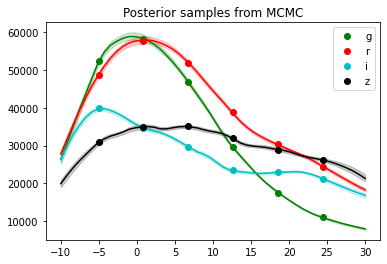

In [78]:
colors  = ['g', 'r', 'c', 'k']
for i, band_flux in enumerate(median_mcmc_fit):
    plt.plot(np.linspace(-10, 30), band_flux, color = colors[i])
    plt.fill_between(np.linspace(-10, 30), upper_mcmc_fit[i], lower_mcmc_fit[i], color = colors[i], alpha = 0.2)
for i, band_flux in enumerate(all_band_fluxes):
  plt.plot(times, band_flux, 'o',color = colors[i], label = bands[i])
plt.legend()
plt.title("Posterior samples from MCMC")

In [79]:
num_corner_samples = 10000
mcmc_corner_samples = mcmc.get_samples(num_samples = num_corner_samples)

In [183]:
vi_corner_samples = Predictive(model_vi, guide = autoguide_vi, num_samples = num_corner_samples)(None,)

In [81]:
custom_vi_corner_samples = Predictive(model_vi, guide = custom_guide, num_samples = num_corner_samples)(None,)

In [82]:
custom_vi_full_eps_corner_samples = Predictive(model_vi, guide = custom_guide_full_eps, num_samples = num_corner_samples)(None,)

In [83]:
laplace_guide = autoguide_laplace.laplace_approximation(torch.as_tensor(all_band_fluxes))

In [84]:
laplace_corner_samples = Predictive(model_vi, guide = laplace_guide, num_samples = num_corner_samples)(None,)

In [85]:
vi_trained_laplace_samples = Predictive(model_vi, guide = new_laplace_approx_guide, num_samples = num_corner_samples)(None,)

In [86]:
mcmc_corner_samples['Av'].shape

torch.Size([10000])

In [87]:
laplace_corner_samples['mu_s'][:,0,0].numpy()

array([34.397118, 34.147957, 34.23435 , ..., 34.227352, 34.375893,
       34.299774], dtype=float32)

In [88]:
laplace_approx = [laplace_corner_samples['mu_s'][:,0,0].detach().numpy()[0], laplace_corner_samples['theta'][:,0,0].detach().numpy()[0], laplace_corner_samples['Av'][:,0,0].detach().numpy()[0]]

In [89]:
laplace_approx

[34.397118, 0.23983672, 0.37635845]

In [150]:
autoguide_from_mcmc = pyro.infer.autoguide.AutoMultivariateNormal(model_vi, init_loc_fn = pyro.infer.autoguide.initialization.init_to_value(values=mcmc_median_vals), init_scale = 0.8)
losses = train(model_vi, autoguide_from_mcmc, lr = 0.005, n_steps = 20000)

[iter 0]  loss: 5905.3137
[iter 500]  loss: 262.5281
[iter 1000]  loss: 412.5439
[iter 1500]  loss: 331.1303
[iter 2000]  loss: 304.5922
[iter 2500]  loss: 217.6897
[iter 3000]  loss: 224.5458
[iter 3500]  loss: 223.6965
[iter 4000]  loss: 215.2545
[iter 4500]  loss: 218.0608
[iter 5000]  loss: 211.2995
[iter 5500]  loss: 217.5005
[iter 6000]  loss: 214.9577
[iter 6500]  loss: 214.5566
[iter 7000]  loss: 217.5243
[iter 7500]  loss: 219.4506
[iter 8000]  loss: 223.4038
[iter 8500]  loss: 226.8111
[iter 9000]  loss: 219.4925
[iter 9500]  loss: 217.9641
[iter 10000]  loss: 223.5125
[iter 10500]  loss: 216.8193
[iter 11000]  loss: 214.1240
[iter 11500]  loss: 216.9077
[iter 12000]  loss: 215.8404
[iter 12500]  loss: 220.4770
[iter 13000]  loss: 216.7312
[iter 13500]  loss: 216.7098
[iter 14000]  loss: 215.8850
[iter 14500]  loss: 212.4714
[iter 15000]  loss: 214.8209
[iter 15500]  loss: 222.3814
[iter 16000]  loss: 213.8020
[iter 16500]  loss: 214.5642
[iter 17000]  loss: 216.3136
[iter 17

In [151]:
vi_from_mcmc_corner_samples = Predictive(model_vi, guide = autoguide_from_mcmc, num_samples = num_corner_samples)(None,)

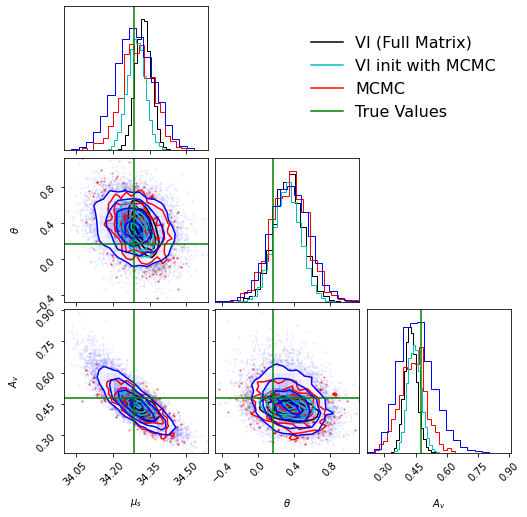

In [209]:
figure = corner.corner(np.vstack((vi_corner_samples['mu_s'][:,0,0].numpy(),vi_corner_samples['theta'][:,0,0].numpy(), 
                                  vi_corner_samples['Av'][:,0,0].numpy())).T, 
                       labels = [r"VI $\mu_s$", r"VI $\theta$", r"VI $A_v$"])
# corner.corner(np.vstack((custom_vi_corner_samples['mu_s'][:,0,0].numpy(),custom_vi_corner_samples['theta'][:,0,0].numpy(), 
#                                  custom_vi_corner_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color ='b')
# corner.corner(np.vstack((custom_vi_full_eps_corner_samples['mu_s'][:,0,0].numpy(),custom_vi_full_eps_corner_samples['theta'][:,0,0].numpy(), 
#                                  custom_vi_full_eps_corner_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color ='c')
# corner.corner(np.vstack((laplace_corner_samples['mu_s'][:,0,0].numpy(),laplace_corner_samples['theta'][:,0,0].numpy(), 
#                                  laplace_corner_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color ='b')
corner.corner(np.vstack((mcmc_corner_samples['mu_s'],mcmc_corner_samples['theta'],mcmc_corner_samples['Av'])).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color ='r')
corner.corner(np.vstack((vi_from_mcmc_corner_samples['mu_s'][:,0,0].numpy(),vi_from_mcmc_corner_samples['theta'][:,0,0].numpy(), 
                                 vi_from_mcmc_corner_samples['Av'][:,0,0].numpy())).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color ='c')
 
corner.corner(np.vstack((vi_trained_laplace_samples['mu_s'][:,0,0].numpy(),vi_trained_laplace_samples['theta'][:,0,0].numpy(), 
                                 vi_trained_laplace_samples['Av'][:,0,0].numpy())).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color ='b')
# corner.corner(np.vstack((mcmc_corner_samples['mu_s'][7500:10000],mcmc_corner_samples['theta'][7500:10000],mcmc_corner_samples['Av'][7500:10000])).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color  = 'r')
# corner.corner(np.vstack((mcmc_corner_samples['mu_s'][2500:5000],mcmc_corner_samples['theta'][2500:5000],mcmc_corner_samples['Av'][2500:5000])).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color  = 'b')
corner.overplot_lines(figure, [true_mu_s, true_theta, true_Av], color = 'g')
# corner.overplot_lines(figure, laplace_approx, color = 'tab:purple')

# colors = ['k','b','c', 'r', 'g', 'tab:purple']
# labels = ['VI (Full Matrix)', 'VI (Custom Matrix)', 'VI (Custom Matrix - Full eps)', 'MCMC', 'True Values', 'Laplace Approx']
colors = ['k','c' ,'r', 'g']

labels = ['VI (Full Matrix)', 'VI init with MCMC', 'MCMC', 'True Values' ]

plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=labels[i])
        for i in range(len(labels))
    ],
    fontsize=16, frameon=False,
    bbox_to_anchor=(1, 3), loc="upper right"
)

In [91]:
mcmc_eps_row_samples = []
mcmc_eps_column_samples = []

vi_eps_row_samples = []
vi_eps_column_samples = []

for i in range(num_corner_samples):
  mcmc_eps_int = np.matmul(L_sigma_epsilon, mcmc_corner_samples['nu'].numpy()[i]).reshape((9,6), order = 'F')
  mcmc_eps_row_samples.append(mcmc_eps_int[1])
  mcmc_eps_column_samples.append(mcmc_eps_int[:,1])

  vi_eps_int = np.matmul(L_sigma_epsilon, vi_corner_samples['nu'][:,0,0].numpy()[i]).reshape((9,6), order = 'F')
  vi_eps_row_samples.append(vi_eps_int[1])
  vi_eps_column_samples.append(vi_eps_int[:,1])


mcmc_eps_row_samples = np.array(mcmc_eps_row_samples)
mcmc_eps_column_samples = np.array(mcmc_eps_column_samples)
vi_eps_row_samples = np.array(vi_eps_row_samples)
vi_eps_column_samples = np.array(vi_eps_column_samples)

mcmc_eps_row_samples.shape, vi_eps_column_samples.shape

((10000, 6), (10000, 9))

In [92]:
true_epsilon_row = true_epsilon_interior.reshape((9,6), order = 'F')[1]
true_epsilon_column = true_epsilon_interior.reshape((9,6), order = 'F')[:,1]

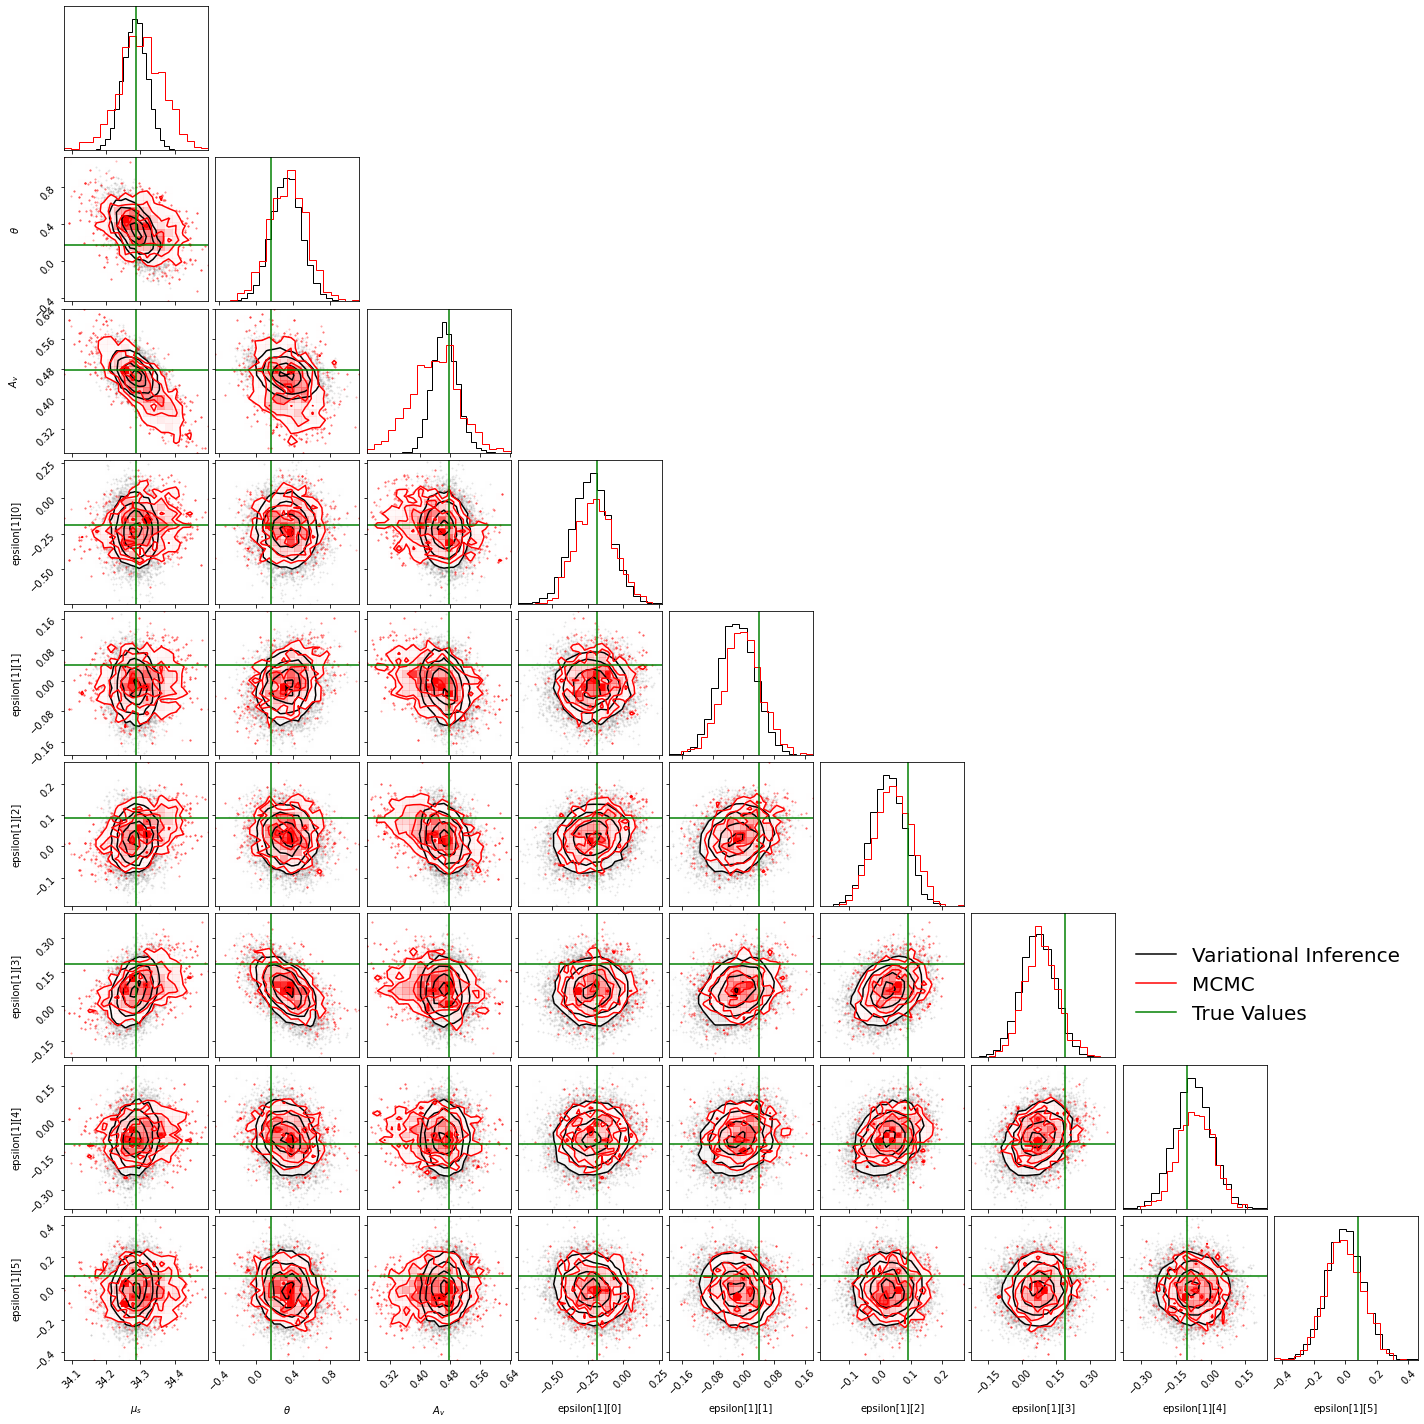

In [93]:
figure = corner.corner(np.vstack((vi_corner_samples['mu_s'][:,0,0].numpy(),vi_corner_samples['theta'][:,0,0].numpy(), 
                                  vi_corner_samples['Av'][:,0,0].numpy(), vi_eps_row_samples.T)).T, 
                       labels = [r"VI $\mu_s$", r"VI $\theta$", r"VI $A_v$"] + ["epsilon[1]["+str(i)+"]" for i in range(9)])
corner.corner(np.vstack((mcmc_corner_samples['mu_s'],mcmc_corner_samples['theta'],mcmc_corner_samples['Av'], mcmc_eps_row_samples.T)).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"] + ["epsilon[1]["+str(i)+"]" for i in range(9)], fig = figure, color ='r')
# corner.corner(np.vstack((mcmc_corner_samples['mu_s'][7500:10000],mcmc_corner_samples['theta'][7500:10000],mcmc_corner_samples['Av'][7500:10000])).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color  = 'r')
# corner.corner(np.vstack((mcmc_corner_samples['mu_s'][2500:5000],mcmc_corner_samples['theta'][2500:5000],mcmc_corner_samples['Av'][2500:5000])).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color  = 'b')
corner.overplot_lines(figure, [true_mu_s, true_theta, true_Av] + list(true_epsilon_row), color = 'g')
colors = ['k', 'r', 'g']
labels = ['Variational Inference', 'MCMC', 'True Values']
plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=labels[i])
        for i in range(len(labels))
    ],
    fontsize=20, frameon=False,
    bbox_to_anchor=(1, 3), loc="upper right"
)
figure.savefig("eps_row_corner_plot.pdf", bbox_inches = 'tight')

ValueError: ignored

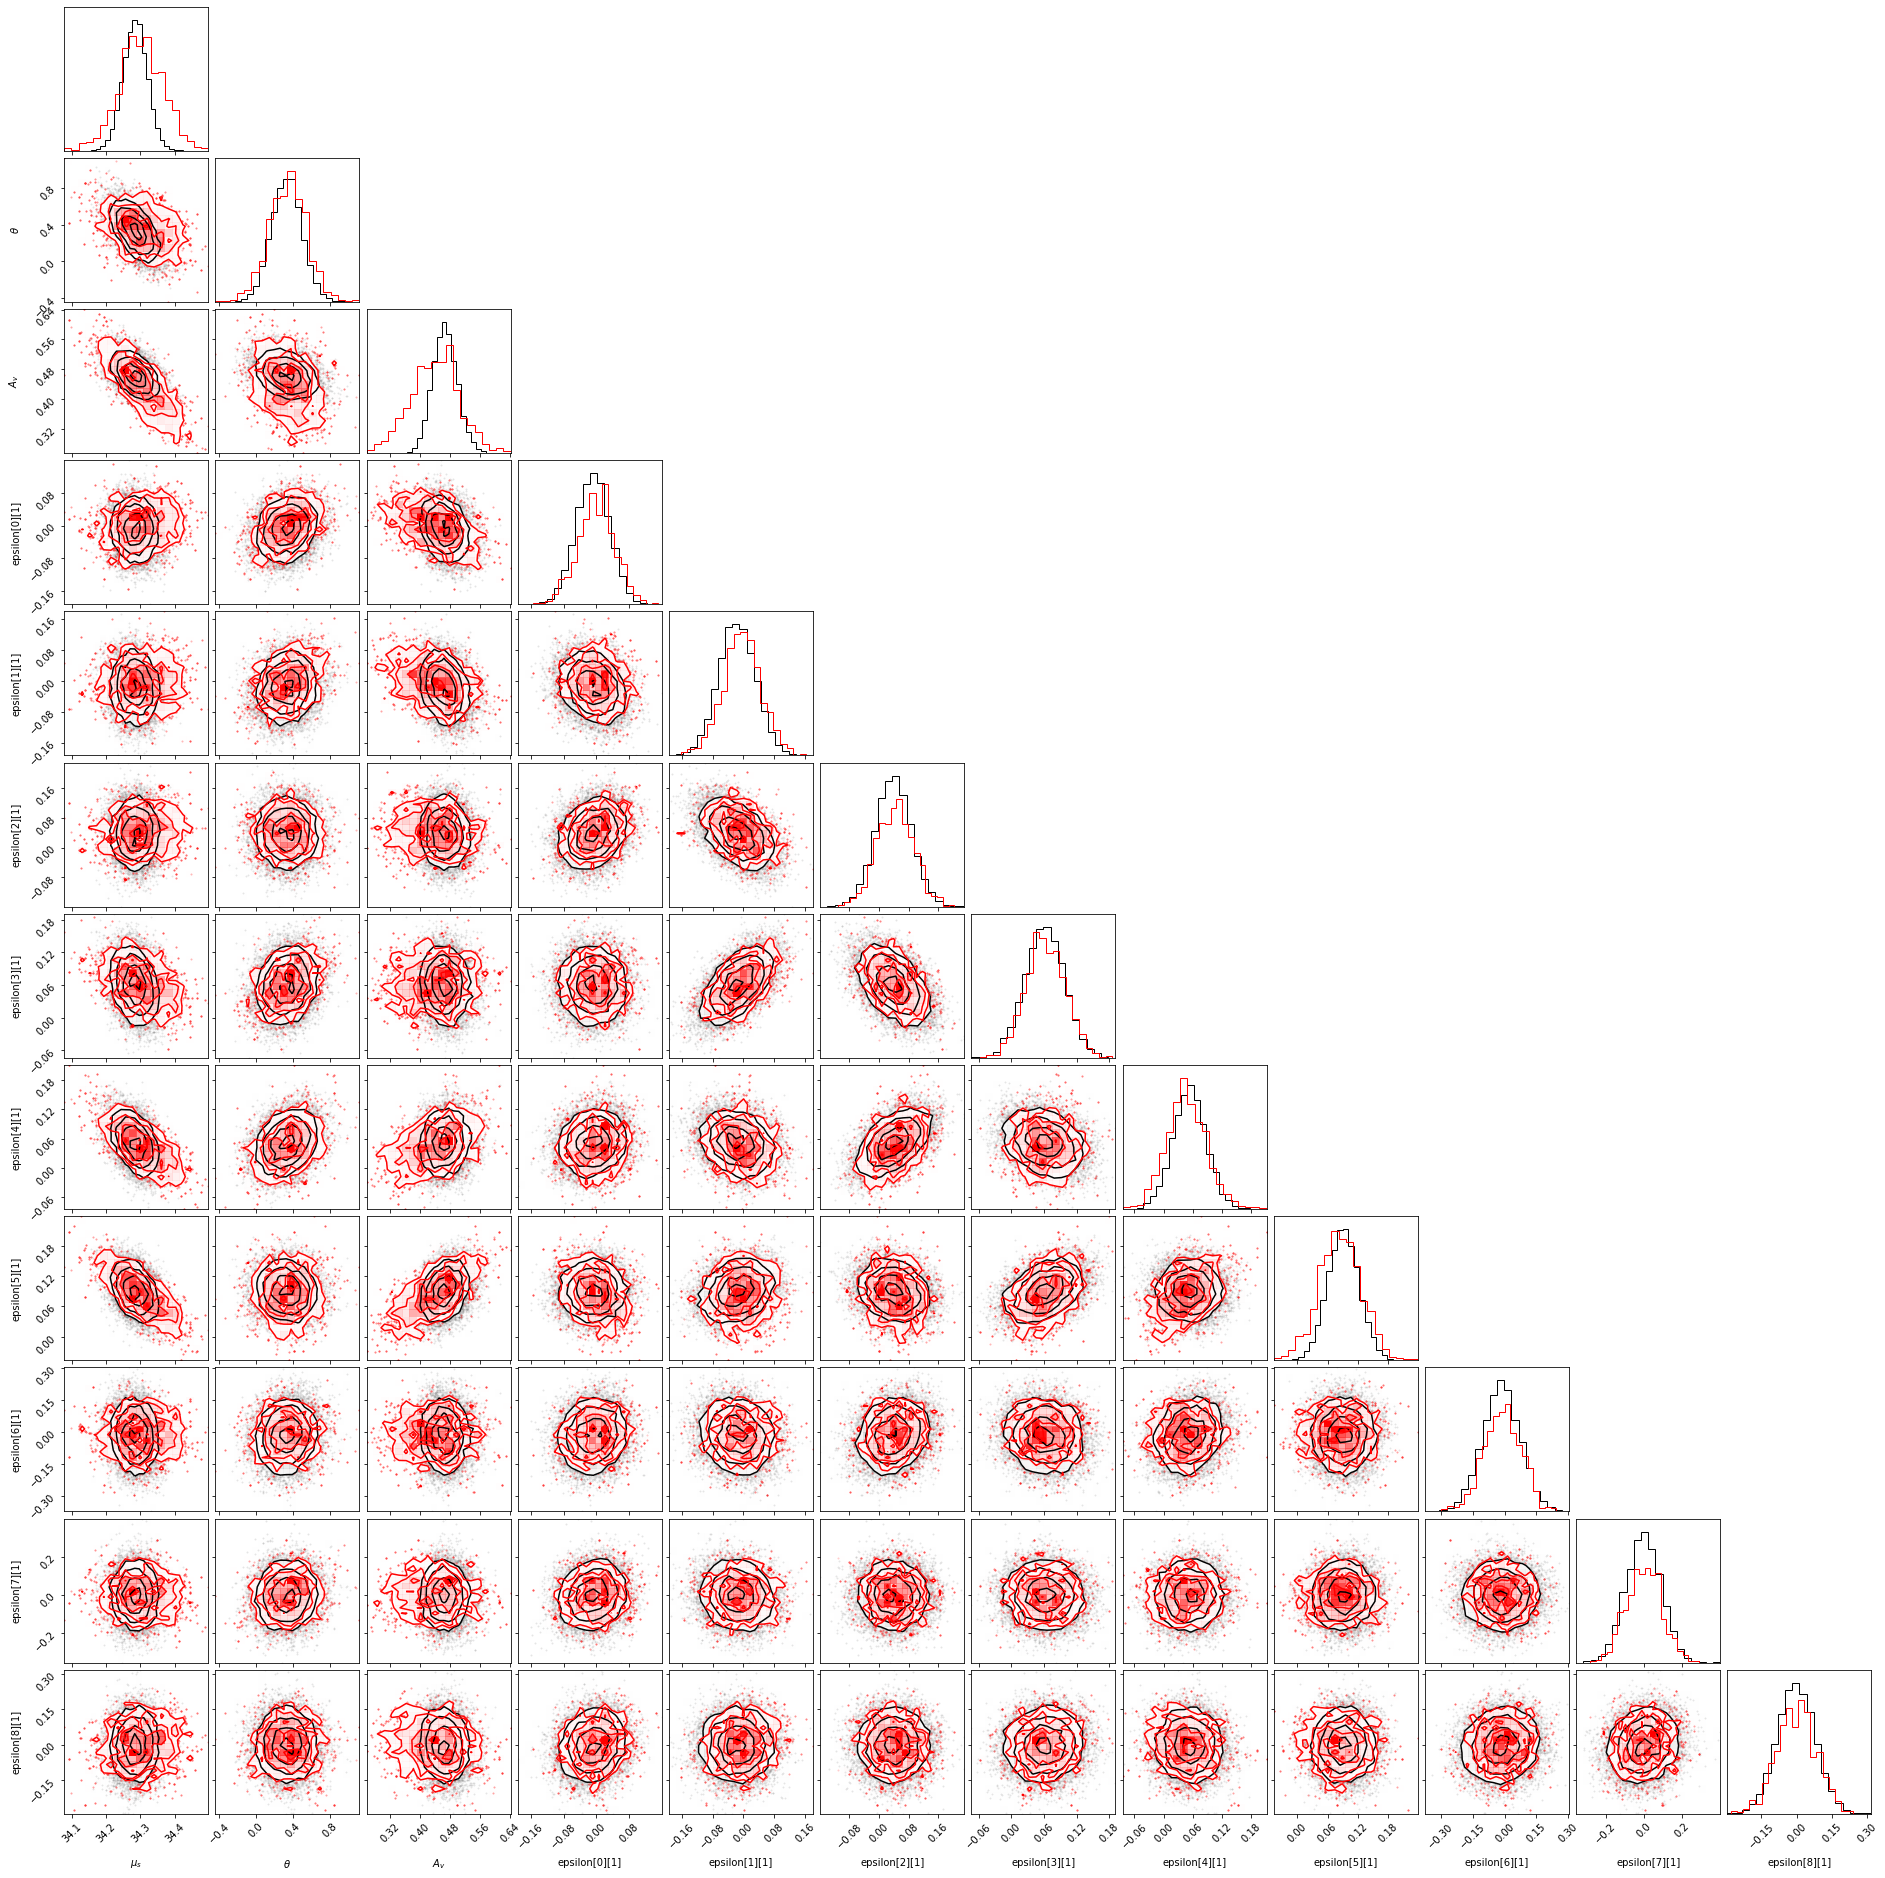

In [94]:
figure = corner.corner(np.vstack((vi_corner_samples['mu_s'][:,0,0].numpy(),vi_corner_samples['theta'][:,0,0].numpy(), 
                                  vi_corner_samples['Av'][:,0,0].numpy(), vi_eps_column_samples.T)).T, 
                       labels = [r"VI $\mu_s$", r"VI $\theta$", r"VI $A_v$"] + ["epsilon[1]["+str(i)+"]" for i in range(9)])
corner.corner(np.vstack((mcmc_corner_samples['mu_s'],mcmc_corner_samples['theta'],mcmc_corner_samples['Av'], mcmc_eps_column_samples.T)).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"] + ["epsilon["+str(i)+"][1]" for i in range(9)], fig = figure, color ='r')

corner.corner(np.vstack((laplace_corner_samples['mu_s'][:,0,0].numpy(),laplace_corner_samples['theta'][:,0,0].numpy(), 
                                 laplace_corner_samples['Av'][:,0,0].numpy())).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color ='tab:purple')
corner.corner(np.vstack((vi_corner_samples['mu_s'][:,0,0].numpy(),vi_corner_samples['theta'][:,0,0].numpy(), 
                                  vi_corner_samples['Av'][:,0,0].numpy(), vi_eps_column_samples.T)).T, 
                       labels = [r"VI $\mu_s$", r"VI $\theta$", r"VI $A_v$"] + ["epsilon[1]["+str(i)+"]" for i in range(9)])
# corner.corner(np.vstack((mcmc_corner_samples['mu_s'][7500:10000],mcmc_corner_samples['theta'][7500:10000],mcmc_corner_samples['Av'][7500:10000])).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color  = 'r')
# corner.corner(np.vstack((mcmc_corner_samples['mu_s'][2500:5000],mcmc_corner_samples['theta'][2500:5000],mcmc_corner_samples['Av'][2500:5000])).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color  = 'b')
corner.overplot_lines(figure, [true_mu_s, true_theta, true_Av] + list(true_epsilon_column), color = 'g')
colors = ['k', 'r', 'g']
labels = ['Variational Inference', 'MCMC', 'True Values']
plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=labels[i])
        for i in range(len(labels))
    ],
    fontsize=20, frameon=False,
    bbox_to_anchor=(1, 3), loc="upper right"
)
figure.savefig("eps_column_corner_plot.pdf", bbox_inches = 'tight')